## Imports and requirements

In [ ]:
# !pip install statsmodels
# !pip install tsai
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [36]:
import os
import tqdm
import torch
import sklearn
import numpy as np
import pandas as pd
import torch.nn as nn
from tsai.basics import *
from tsai.inference import load_learner
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error



os.environ["DEVICE"] = "cuda" 

## Cargar datos y otros análisis

In [8]:
jara = pd.read_csv('./data/jara_processed.csv').set_index('date')
pena = pd.read_csv('./data/pena_processed.csv').set_index('date')
minon = pd.read_csv('./data/minon_processed.csv').set_index('date')

In [9]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

def split_data(df, train_ratio, val_ratio, test_ratio):
    df = df.sort_index()

    train_size = int(len(df) * train_ratio)
    val_size = int(len(df) * val_ratio)
    test_size = len(df) - train_size - val_size

    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:train_size + val_size]
    test_df = df.iloc[train_size + val_size:]

    return train_df, val_df, test_df

jara_train, jara_val, jara_test = split_data(jara, train_ratio, val_ratio, test_ratio)
pena_train, pena_val, pena_test = split_data(pena, train_ratio, val_ratio, test_ratio)
minon_train, minon_val, minon_test = split_data(minon, train_ratio, val_ratio, test_ratio)


Con las correlaciones totales y parciales podemos detectar que se mantiene una correlación alta hasta 24 horas atrás. Esto nos puede ayudar a decidir la ventana de contexto que utilicemos para entrenar los diferentes modelos.

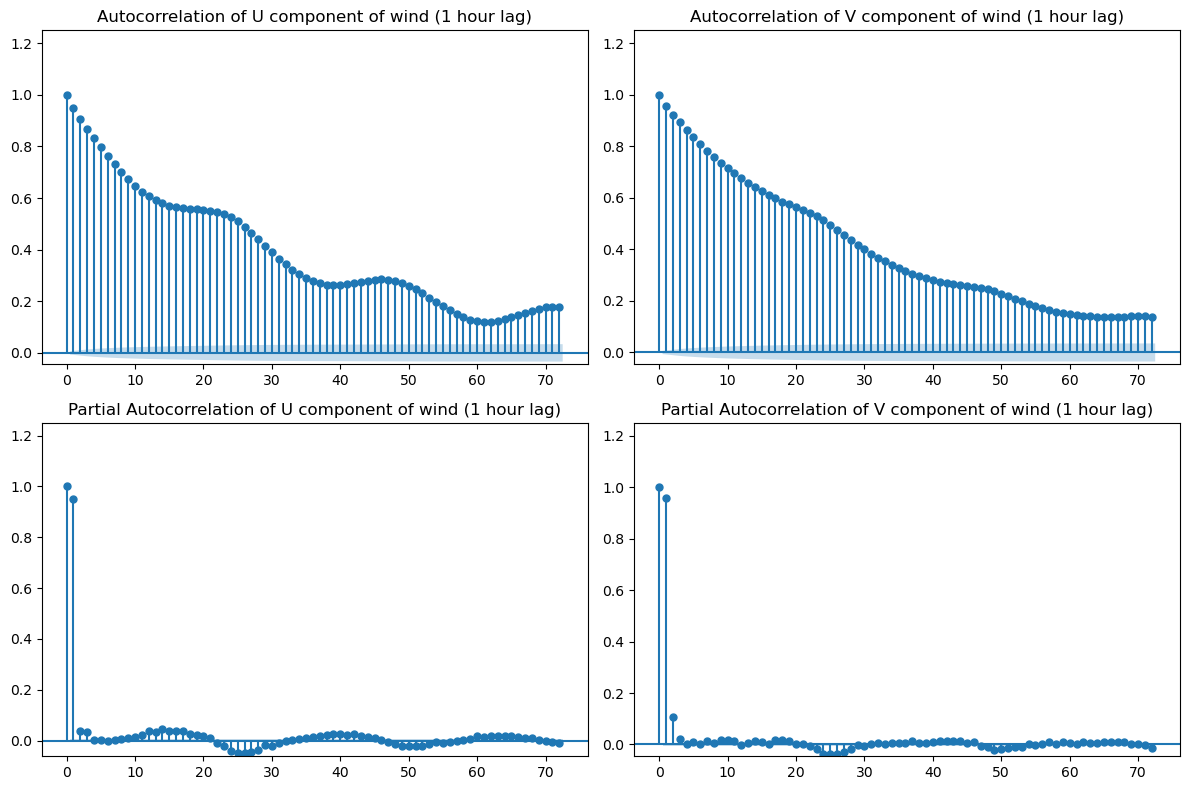

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

plot_acf(jara['U'], lags=72, auto_ylims=True, ax=axes[0, 0], title='Autocorrelation of U component of wind (1 hour lag)')
plot_acf(jara['V'], lags=72, auto_ylims=True, ax=axes[0, 1], title='Autocorrelation of V component of wind (1 hour lag)')
plot_pacf(jara['U'], lags=72, auto_ylims=True, method='ywm', ax=axes[1, 0], title='Partial Autocorrelation of U component of wind (1 hour lag)')
plot_pacf(jara['V'], lags=72, auto_ylims=True, method='ywm', ax=axes[1, 1], title='Partial Autocorrelation of V component of wind (1 hour lag)')

plt.tight_layout()
plt.show()


## Baseline

Como primera baseline para comparar nuestros modelos utilizaremos persistencia sobre un horizonte de predicción de 12 h.

In [4]:
# Implementar la baseline de persistencia
def persistence_baseline(data, horizon):
    predictions = []
    true_values = []
    for i in range(len(data) - horizon):
        last_value = data.iloc[i]
        pred = [last_value] * horizon
        predictions.append(pred)
        true_values.append(data.iloc[i+1:i+horizon+1].values)
    return np.array(predictions), np.array(true_values)

# Evaluar el rendimiento de la baseline
def evaluate_performance(predictions, true_values):
    mse_scores = []
    for i in range(predictions.shape[1]):
        mse = mean_squared_error(true_values[:, i], predictions[:, i])
        mse_scores.append(mse)
    return mse_scores


In [5]:
horizon = 12

for dataset_name, dataset in [('jara', jara_test), ('pena', pena_test), ('minon', minon_test)]:
    predictions_U, true_values_U = persistence_baseline(dataset['U'], horizon)
    predictions_V, true_values_V = persistence_baseline(dataset['V'], horizon)

    mse_U = evaluate_performance(predictions_U, true_values_U)
    mse_V = evaluate_performance(predictions_V, true_values_V)

    print(f"Resultados para {dataset_name}:")
    print(f"Errores MSE para U: {np.mean(mse_U):.2f} {mse_U}")
    print(f"Errores MSE para V: {np.mean(mse_V):.2f} {mse_V}")


Resultados para jara:
Errores MSE para U: 0.47 [0.10230539285516575, 0.1890281158901961, 0.2610199478582012, 0.33260435016026174, 0.4003816471872532, 0.4643920782973107, 0.5242742475037213, 0.5813289631260284, 0.6343159427293781, 0.6816932002514274, 0.720759228455777, 0.7550545533569731]
Errores MSE para V: 0.37 [0.0967308439324283, 0.15717234183445253, 0.2115677020181572, 0.2689517813364556, 0.3119841622761421, 0.3611484717955262, 0.40929774915791134, 0.4524899587345736, 0.49177818768210796, 0.5230902679713254, 0.5553940023013346, 0.5897211787684835]
Resultados para pena:
Errores MSE para U: 1.06 [0.68228016396843, 0.7762825969151521, 0.8610405201757492, 0.9439300272355069, 1.0090357327155384, 1.0710768607146373, 1.1288533331939463, 1.1800239196752433, 1.2284642317761703, 1.250691301931634, 1.2735917494906699, 1.2929318526253242]
Errores MSE para V: 0.69 [0.296351645756906, 0.40748056708216096, 0.4839607986667687, 0.5559767961195763, 0.6230174365463129, 0.6863985901225856, 0.749042482

## N-Hits Implementation

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



El algoritmo N-HITS (Neural Hierarchical Interpolation for Time Series) es un modelo avanzado de predicción de series temporales que combina múltiples bloques (o "modules") para mejorar la precisión de las predicciones. Cada bloque del modelo se encarga de una parte del proceso de predicción y sus resultados se combinan para obtener la predicción final.

Definición del Modelo N-HITS:

- NHITSBlock: Es el bloque básico del modelo, que contiene capas lineales (fc1, fc2, fc3) con funciones de activación ReLU.
- NHITS: Es el modelo completo que consta de múltiples bloques NHITSBlock. Los resultados de todos los bloques se promedian para obtener la predicción final.

In [19]:
### USING GPU

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Define the N-HiTS Model
class NHITSBlock(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NHITSBlock, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class NHITS(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_blocks):
        super(NHITS, self).__init__()
        self.blocks = nn.ModuleList(
            [NHITSBlock(input_size, hidden_size, output_size) for _ in range(num_blocks)]
        )

    def forward(self, x):
        outputs = []
        for block in self.blocks:
            output = block(x)
            outputs.append(output)
        return torch.stack(outputs, dim=1).mean(dim=1)  # Averaging the outputs from all blocks


# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, horizon, input_size):
        self.data = data
        self.horizon = horizon
        self.input_size = input_size

    def __len__(self):
        return len(self.data) - self.horizon - self.input_size

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.input_size].values
        y = self.data[idx + self.input_size:idx + self.input_size + self.horizon].values
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# Prepare Data
def prepare_data(data, horizon, input_size):
    dataset = TimeSeriesDataset(data, horizon, input_size)
    return DataLoader(dataset, batch_size=2048, shuffle=True)

# Train Function
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    model.to(device)  # Move model to the device
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

# Evaluate Performance
def evaluate_performance(model, test_loader):
    model.to(device)  # Move model to the device
    predictions = []
    true_values = []
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
            true_values.append(targets.cpu().numpy())

    predictions = np.concatenate(predictions)
    true_values = np.concatenate(true_values)
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    return mse, mae, predictions, true_values


# Plotting the results
def plot_predictions(true_values, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label='True Values')
    plt.plot(predictions, label='Predicted Values', linestyle='--')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

Using device: cuda



### Training a model for each dataset with fixed hyperparameters

En esta primera prueba, se entrenará un modelo para cada dataset (jara, pena, minon) y será el que se utilice para predecir la serie del conjunto de datos para el que ha sido especialmente entrenado. Se fijarán unos hiperparametros estandares para comprobar su funcionamiento

In [37]:
# Hyperparameters
input_size = 24  # Number of input time steps
horizon = 12  # Number of output time steps
hidden_size = 128  # Hidden layer size
num_blocks = 3  # Number of N-HiTS blocks
num_epochs = 25  # Number of epochs
learning_rate = 0.001  # Learning rate

In [42]:
## JARA TRAIN
train_loader_jara = prepare_data(jara_train['U'], horizon, input_size)
val_loader_jara = prepare_data(jara_val['U'], horizon, input_size)
test_loader_jara = prepare_data(jara_test['U'], horizon, input_size)

model_jara = NHITS(input_size, hidden_size, horizon, num_blocks) #Initialize
train_model(model_jara, train_loader_jara, val_loader_jara, num_epochs, learning_rate) #Train model


## PENA TRAIN
train_loader_pena = prepare_data(pena_train['U'], horizon, input_size)
val_loader_pena = prepare_data(pena_val['U'], horizon, input_size)
test_loader_pena = prepare_data(pena_test['U'], horizon, input_size)

model_pena = NHITS(input_size, hidden_size, horizon, num_blocks) 
train_model(model_pena, train_loader_pena, val_loader_pena, num_epochs, learning_rate)


## MINON TRAIN
train_loader_minon = prepare_data(minon_train['U'], horizon, input_size)
val_loader_minon = prepare_data(minon_val['U'], horizon, input_size)
test_loader_minon = prepare_data(minon_test['U'], horizon, input_size)

model_minon = NHITS(input_size, hidden_size, horizon, num_blocks)
train_model(model_jara, train_loader_minon, val_loader_minon, num_epochs, learning_rate)

Evaluating on Jara Test Set
MSE: 0.3567
MAE: 0.4489

Evaluating on Pena Test Set
MSE: 0.6367
MAE: 0.5498

Evaluating on Minon Test Set
MSE: 1.0339
MAE: 0.8693

Average MSE: 0.676
Average MAE: 0.623


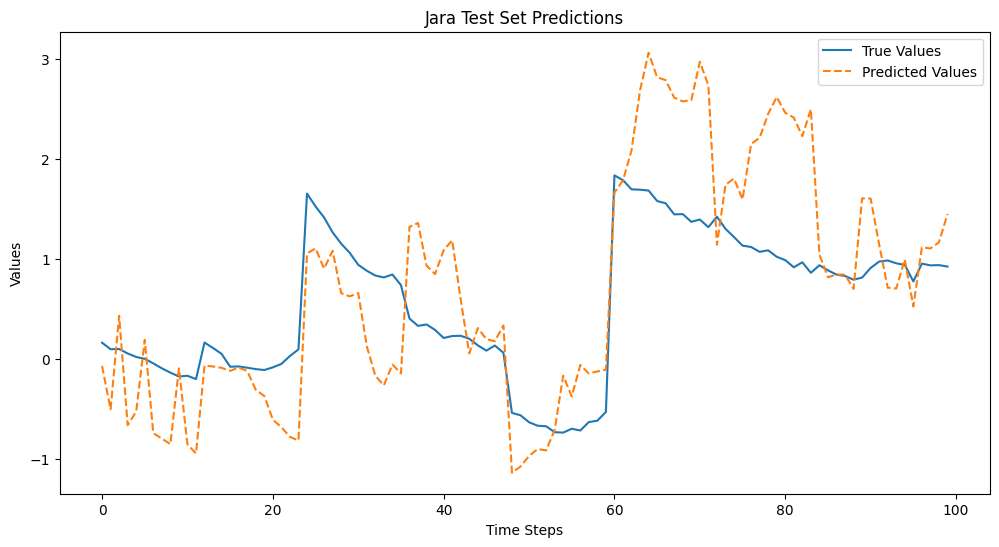

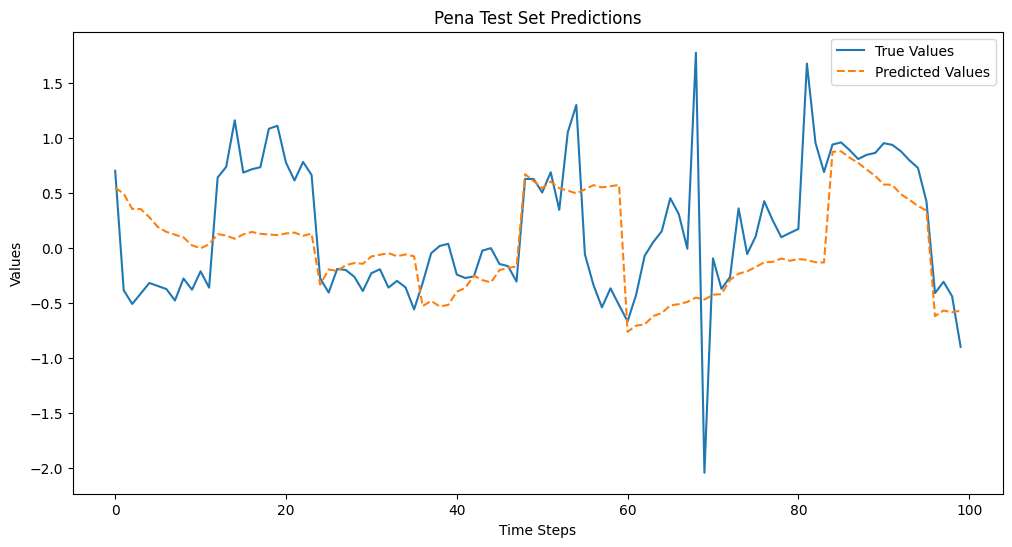

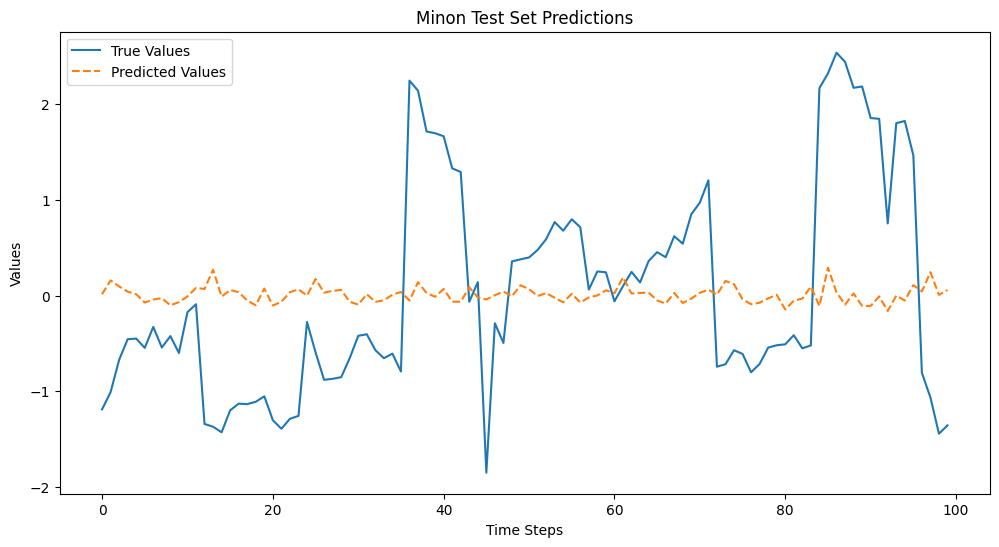

In [43]:
# Evaluate the model on each test dataset and get predictions
print("Evaluating on Jara Test Set")
jara_mse, jara_mae, jara_predictions, jara_true_values = evaluate_performance(model_jara, test_loader_jara)
jara_predictions = jara_predictions.flatten()
jara_true_values = jara_true_values.flatten()

print("\nEvaluating on Pena Test Set")
pena_mse, pena_mae, pena_predictions, pena_true_values = evaluate_performance(model_pena, test_loader_pena)
pena_predictions = pena_predictions.flatten()
pena_true_values = pena_true_values.flatten()

print("\nEvaluating on Minon Test Set")
minon_mse, minon_mae, minon_predictions, minon_true_values = evaluate_performance(model_minon, test_loader_minon)
minon_predictions = minon_predictions.flatten()
minon_true_values = minon_true_values.flatten()

# Average metrics
avg_mse = (jara_mse + pena_mse + minon_mse) / 3
avg_mae = (jara_mae + pena_mae + minon_mae) / 3
print(f"\nAverage MSE: {avg_mse:.3f}\nAverage MAE: {avg_mae:.3f}")

plot_predictions(jara_true_values[:100], jara_predictions[:100], 'Jara Test Set Predictions')
plot_predictions(pena_true_values[:100], pena_predictions[:100], 'Pena Test Set Predictions')
plot_predictions(minon_true_values[:100], minon_predictions[:100], 'Minon Test Set Predictions')

### Training a model for each dataset using a grid search

En esta segunda prueba, se entrenará un modelo para cada dataset (jara, pena, minon) igual que en la prueba anterior, pero se buscara una combinacion de hiperparámetros que nos ofrezcan unos buenos resultados mediante gridsearch

In [43]:
# Define the grid of hyperparameters
input_size_grid = [12, 24, 48]
hidden_size_grid = [64, 128, 256]
num_blocks_grid = [1, 3, 5]
num_epochs_grid = [25]
learning_rate_grid = [0.001]

# Function to perform grid search
def grid_search():
    best_mse_jara = float('inf')
    best_params_jara = {}
    best_mse_pena = float('inf')
    best_params_pena = {}
    best_mse_minon = float('inf')
    best_params_minon = {}
    
    for input_size in input_size_grid:
        for hidden_size in hidden_size_grid:
            for num_blocks in num_blocks_grid:
                for num_epochs in num_epochs_grid:
                    for learning_rate in learning_rate_grid:
                        print(f"Evaluating configuration: input_size={input_size}, hidden_size={hidden_size}, num_blocks={num_blocks}, num_epochs={num_epochs}, learning_rate={learning_rate}")
                        
                        # Create data loaders for each iteration
                        train_loader_jara = prepare_data(jara_train['U'], horizon, input_size)
                        val_loader_jara = prepare_data(jara_val['U'], horizon, input_size)
                        test_loader_jara = prepare_data(jara_test['U'], horizon, input_size)

                        train_loader_pena = prepare_data(pena_train['U'], horizon, input_size)
                        val_loader_pena = prepare_data(pena_val['U'], horizon, input_size)
                        test_loader_pena = prepare_data(pena_test['U'], horizon, input_size)

                        train_loader_minon = prepare_data(minon_train['U'], horizon, input_size)
                        val_loader_minon = prepare_data(minon_val['U'], horizon, input_size)
                        test_loader_minon = prepare_data(minon_test['U'], horizon, input_size)
                        
                        # JARA
                        model_jara = NHITS(input_size, hidden_size, horizon, num_blocks)
                        train_model(model_jara, train_loader_jara, val_loader_jara, num_epochs, learning_rate)
                        mse_jara, _ = evaluate_performance(model_jara, test_loader_jara)
                        if mse_jara < best_mse_jara:
                            best_mse_jara = mse_jara
                            best_params_jara = {
                                'input_size': input_size,
                                'hidden_size': hidden_size,
                                'num_blocks': num_blocks,
                                'num_epochs': num_epochs,
                                'learning_rate': learning_rate
                            }

                        # PENA
                        model_pena = NHITS(input_size, hidden_size, horizon, num_blocks)
                        train_model(model_pena, train_loader_pena, val_loader_pena, num_epochs, learning_rate)
                        mse_pena, _ = evaluate_performance(model_pena, test_loader_pena)
                        if mse_pena < best_mse_pena:
                            best_mse_pena = mse_pena
                            best_params_pena = {
                                'input_size': input_size,
                                'hidden_size': hidden_size,
                                'num_blocks': num_blocks,
                                'num_epochs': num_epochs,
                                'learning_rate': learning_rate
                            }

                        # MINON
                        model_minon = NHITS(input_size, hidden_size, horizon, num_blocks)
                        train_model(model_minon, train_loader_minon, val_loader_minon, num_epochs, learning_rate)
                        mse_minon, _ = evaluate_performance(model_minon, test_loader_minon)
                        if mse_minon < best_mse_minon:
                            best_mse_minon = mse_minon
                            best_params_minon = {
                                'input_size': input_size,
                                'hidden_size': hidden_size,
                                'num_blocks': num_blocks,
                                'num_epochs': num_epochs,
                                'learning_rate': learning_rate
                            }

    print("\nBest configuration for JARA:", best_params_jara, "with MSE:", best_mse_jara)
    print("Best configuration for PENA:", best_params_pena, "with MSE:", best_mse_pena)
    print("Best configuration for MINON:", best_params_minon, "with MSE:", best_mse_minon)

grid_search()

Evaluating configuration: input_size=12, hidden_size=64, num_blocks=1, num_epochs=25, learning_rate=0.001
Epoch 1, Train Loss: 0.6733, Val Loss: 0.4855
Epoch 2, Train Loss: 0.4302, Val Loss: 0.4109
Epoch 3, Train Loss: 0.3919, Val Loss: 0.3986
Epoch 4, Train Loss: 0.3835, Val Loss: 0.3942
Epoch 5, Train Loss: 0.3807, Val Loss: 0.3916
Epoch 6, Train Loss: 0.3791, Val Loss: 0.3914
Epoch 7, Train Loss: 0.3780, Val Loss: 0.3896
Epoch 8, Train Loss: 0.3772, Val Loss: 0.3902
Epoch 9, Train Loss: 0.3767, Val Loss: 0.3896
Epoch 10, Train Loss: 0.3767, Val Loss: 0.3887
Epoch 11, Train Loss: 0.3762, Val Loss: 0.3891
Epoch 12, Train Loss: 0.3755, Val Loss: 0.3884
Epoch 13, Train Loss: 0.3752, Val Loss: 0.3875
Epoch 14, Train Loss: 0.3750, Val Loss: 0.3873
Epoch 15, Train Loss: 0.3746, Val Loss: 0.3877
Epoch 16, Train Loss: 0.3746, Val Loss: 0.3881
Epoch 17, Train Loss: 0.3743, Val Loss: 0.3881
Epoch 18, Train Loss: 0.3738, Val Loss: 0.3866
Epoch 19, Train Loss: 0.3735, Val Loss: 0.3879
Epoch 20, 

In [48]:
# Hyperparameters
input_size = 48  # Number of input time steps
horizon = 12  # Number of output time steps
hidden_size = 128  # Hidden layer size
num_blocks = 3  # Number of N-HiTS blocks
num_epochs = 25  # Number of epochs
learning_rate = 0.001  # Learning rate

#### U

In [49]:
### U

## JARA TRAIN
train_loader_jara = prepare_data(jara_train['U'], horizon, input_size)
val_loader_jara = prepare_data(jara_val['U'], horizon, input_size)
test_loader_jara = prepare_data(jara_test['U'], horizon, input_size)

model_jara = NHITS(input_size, hidden_size, horizon, num_blocks) #Initialize
train_model(model_jara, train_loader_jara, val_loader_jara, num_epochs, learning_rate) #Train model


## PENA TRAIN
train_loader_pena = prepare_data(pena_train['U'], horizon, input_size)
val_loader_pena = prepare_data(pena_val['U'], horizon, input_size)
test_loader_pena = prepare_data(pena_test['U'], horizon, input_size)

model_pena = NHITS(input_size, hidden_size, horizon, num_blocks) 
train_model(model_pena, train_loader_pena, val_loader_pena, num_epochs, learning_rate)


## MINON TRAIN
train_loader_minon = prepare_data(minon_train['U'], horizon, input_size)
val_loader_minon = prepare_data(minon_val['U'], horizon, input_size)
test_loader_minon = prepare_data(minon_test['U'], horizon, input_size)

model_minon = NHITS(input_size, hidden_size, horizon, num_blocks)
train_model(model_minon, train_loader_minon, val_loader_minon, num_epochs, learning_rate)

Epoch 1, Train Loss: 0.5802, Val Loss: 0.4207
Epoch 2, Train Loss: 0.3777, Val Loss: 0.3759
Epoch 3, Train Loss: 0.3537, Val Loss: 0.3640
Epoch 4, Train Loss: 0.3468, Val Loss: 0.3611
Epoch 5, Train Loss: 0.3435, Val Loss: 0.3580
Epoch 6, Train Loss: 0.3415, Val Loss: 0.3558
Epoch 7, Train Loss: 0.3391, Val Loss: 0.3560
Epoch 8, Train Loss: 0.3381, Val Loss: 0.3528
Epoch 9, Train Loss: 0.3368, Val Loss: 0.3545
Epoch 10, Train Loss: 0.3355, Val Loss: 0.3530
Epoch 11, Train Loss: 0.3341, Val Loss: 0.3509
Epoch 12, Train Loss: 0.3334, Val Loss: 0.3516
Epoch 13, Train Loss: 0.3319, Val Loss: 0.3505
Epoch 14, Train Loss: 0.3313, Val Loss: 0.3518
Epoch 15, Train Loss: 0.3308, Val Loss: 0.3498
Epoch 16, Train Loss: 0.3311, Val Loss: 0.3524
Epoch 17, Train Loss: 0.3281, Val Loss: 0.3501
Epoch 18, Train Loss: 0.3274, Val Loss: 0.3493
Epoch 19, Train Loss: 0.3270, Val Loss: 0.3513
Epoch 20, Train Loss: 0.3264, Val Loss: 0.3507
Epoch 21, Train Loss: 0.3252, Val Loss: 0.3490
Epoch 22, Train Loss: 

Evaluating on Jara Test Set
MSE: 0.3343
MAE: 0.4263

Evaluating on Pena Test Set
MSE: 0.6146
MAE: 0.5309

Evaluating on Minon Test Set
MSE: 0.4011
MAE: 0.4537

Average MSE: 0.450
Average MAE: 0.470


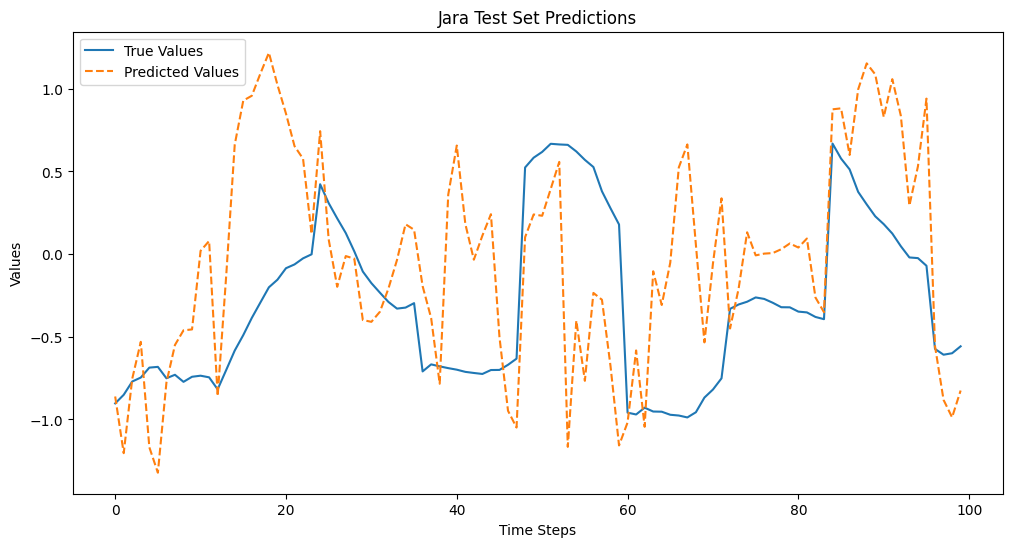

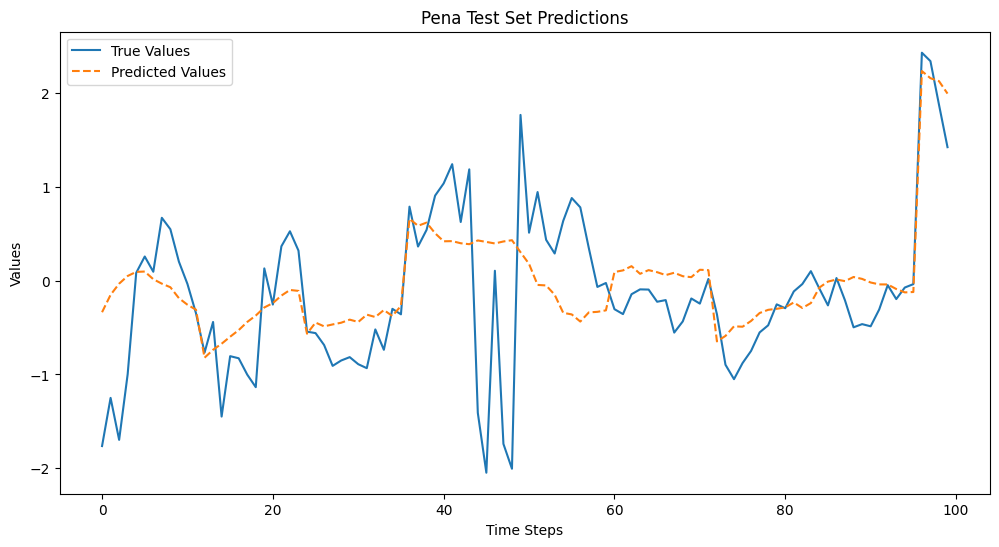

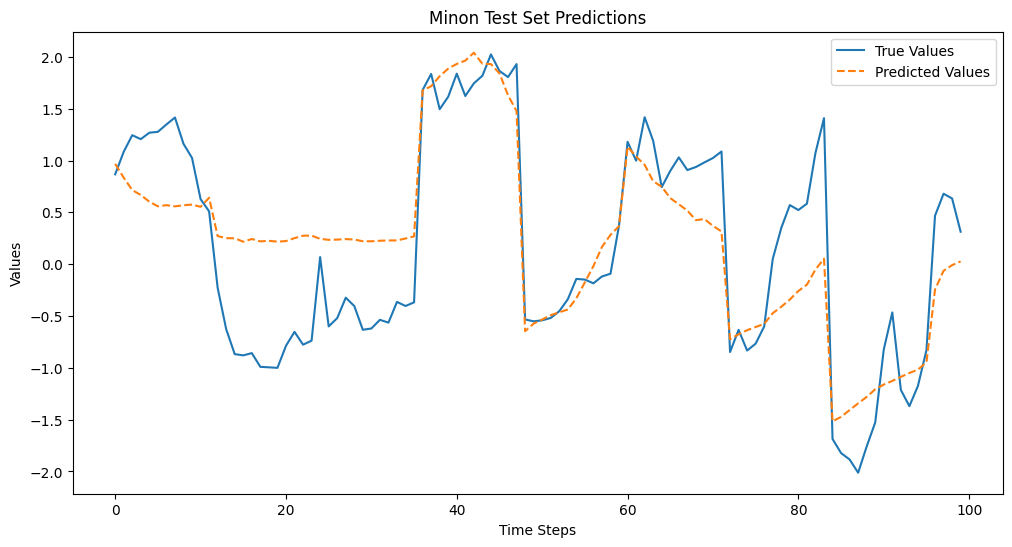

In [50]:
# Evaluate the model on each test dataset and get predictions
print("Evaluating on Jara Test Set")
jara_mse, jara_mae, jara_predictions, jara_true_values = evaluate_performance(model_jara, test_loader_jara)
jara_predictions = jara_predictions.flatten()
jara_true_values = jara_true_values.flatten()

print("\nEvaluating on Pena Test Set")
pena_mse, pena_mae, pena_predictions, pena_true_values = evaluate_performance(model_pena, test_loader_pena)
pena_predictions = pena_predictions.flatten()
pena_true_values = pena_true_values.flatten()

print("\nEvaluating on Minon Test Set")
minon_mse, minon_mae, minon_predictions, minon_true_values = evaluate_performance(model_minon, test_loader_minon)
minon_predictions = minon_predictions.flatten()
minon_true_values = minon_true_values.flatten()

# Average metrics
avg_mse = (jara_mse + pena_mse + minon_mse) / 3
avg_mae = (jara_mae + pena_mae + minon_mae) / 3
print(f"\nAverage MSE: {avg_mse:.3f}\nAverage MAE: {avg_mae:.3f}")

plot_predictions(jara_true_values[:100], jara_predictions[:100], 'Jara Test Set Predictions')
plot_predictions(pena_true_values[:100], pena_predictions[:100], 'Pena Test Set Predictions')
plot_predictions(minon_true_values[:100], minon_predictions[:100], 'Minon Test Set Predictions')

#### V

In [51]:
### V

## JARA TRAIN
train_loader_jara = prepare_data(jara_train['V'], horizon, input_size)
val_loader_jara = prepare_data(jara_val['V'], horizon, input_size)
test_loader_jara = prepare_data(jara_test['V'], horizon, input_size)

model_jara = NHITS(input_size, hidden_size, horizon, num_blocks) #Initialize
train_model(model_jara, train_loader_jara, val_loader_jara, num_epochs, learning_rate) #Train model


## PENA TRAIN
train_loader_pena = prepare_data(pena_train['V'], horizon, input_size)
val_loader_pena = prepare_data(pena_val['V'], horizon, input_size)
test_loader_pena = prepare_data(pena_test['V'], horizon, input_size)

model_pena = NHITS(input_size, hidden_size, horizon, num_blocks) 
train_model(model_pena, train_loader_pena, val_loader_pena, num_epochs, learning_rate)


## MINON TRAIN
train_loader_minon = prepare_data(minon_train['V'], horizon, input_size)
val_loader_minon = prepare_data(minon_val['V'], horizon, input_size)
test_loader_minon = prepare_data(minon_test['V'], horizon, input_size)

model_minon = NHITS(input_size, hidden_size, horizon, num_blocks)
train_model(model_minon, train_loader_minon, val_loader_minon, num_epochs, learning_rate)

Epoch 1, Train Loss: 0.5731, Val Loss: 0.3826
Epoch 2, Train Loss: 0.3607, Val Loss: 0.3326
Epoch 3, Train Loss: 0.3329, Val Loss: 0.3202
Epoch 4, Train Loss: 0.3253, Val Loss: 0.3176
Epoch 5, Train Loss: 0.3213, Val Loss: 0.3137
Epoch 6, Train Loss: 0.3193, Val Loss: 0.3131
Epoch 7, Train Loss: 0.3179, Val Loss: 0.3123
Epoch 8, Train Loss: 0.3170, Val Loss: 0.3110
Epoch 9, Train Loss: 0.3170, Val Loss: 0.3111
Epoch 10, Train Loss: 0.3160, Val Loss: 0.3118
Epoch 11, Train Loss: 0.3145, Val Loss: 0.3124
Epoch 12, Train Loss: 0.3143, Val Loss: 0.3107
Epoch 13, Train Loss: 0.3139, Val Loss: 0.3105
Epoch 14, Train Loss: 0.3139, Val Loss: 0.3113
Epoch 15, Train Loss: 0.3135, Val Loss: 0.3118
Epoch 16, Train Loss: 0.3123, Val Loss: 0.3111
Epoch 17, Train Loss: 0.3115, Val Loss: 0.3120
Epoch 18, Train Loss: 0.3109, Val Loss: 0.3100
Epoch 19, Train Loss: 0.3100, Val Loss: 0.3103
Epoch 20, Train Loss: 0.3092, Val Loss: 0.3084
Epoch 21, Train Loss: 0.3089, Val Loss: 0.3107
Epoch 22, Train Loss: 

Evaluating on Jara Test Set
MSE: 0.3038
MAE: 0.4056

Evaluating on Pena Test Set
MSE: 0.4808
MAE: 0.5046

Evaluating on Minon Test Set
MSE: 0.3475
MAE: 0.4238

Average MSE: 0.377
Average MAE: 0.445


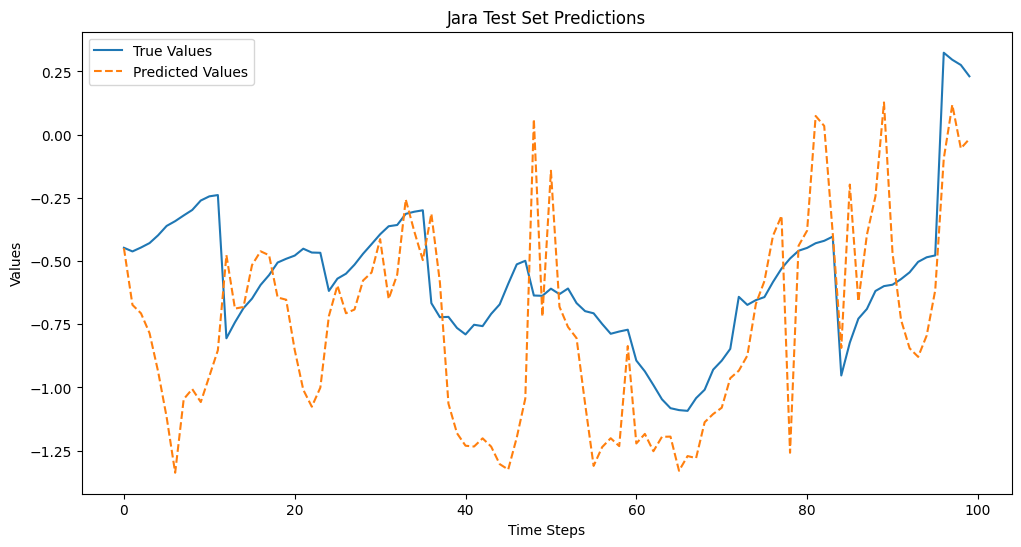

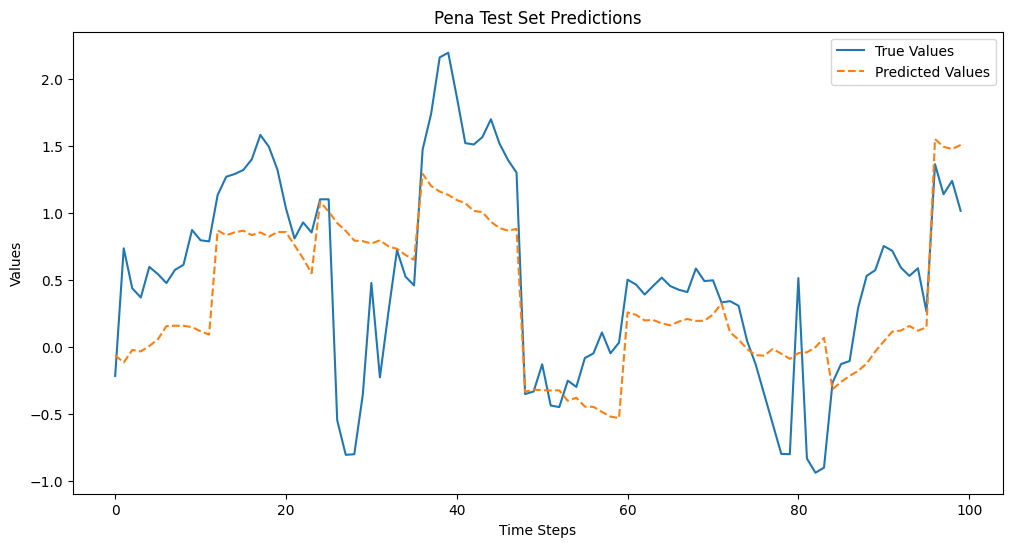

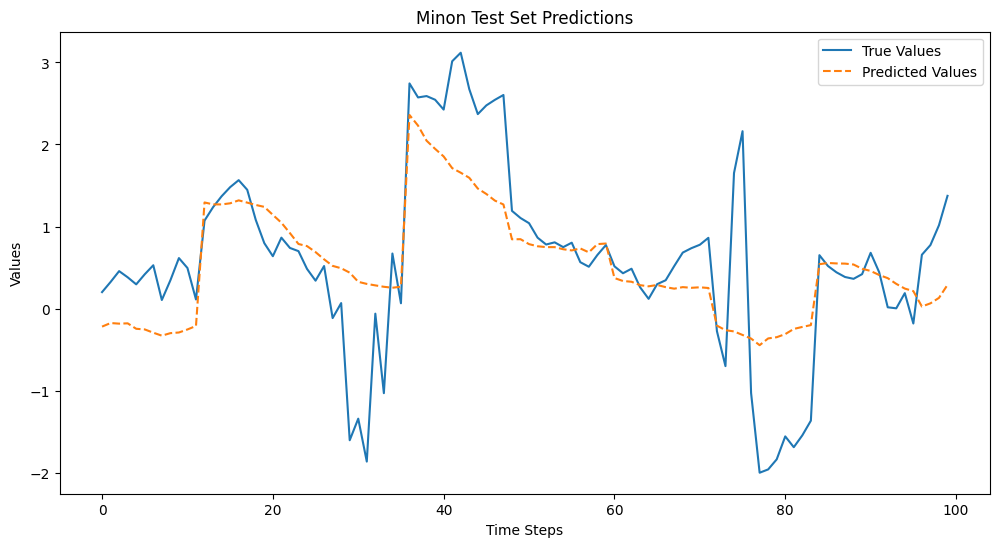

In [55]:
# Evaluate the model on each test dataset and get predictions
print("Evaluating on Jara Test Set")
jara_mse, jara_mae, jara_predictions, jara_true_values = evaluate_performance(model_jara, test_loader_jara)
jara_predictions = jara_predictions.flatten()
jara_true_values = jara_true_values.flatten()

print("\nEvaluating on Pena Test Set")
pena_mse, pena_mae, pena_predictions, pena_true_values = evaluate_performance(model_pena, test_loader_pena)
pena_predictions = pena_predictions.flatten()
pena_true_values = pena_true_values.flatten()

print("\nEvaluating on Minon Test Set")
minon_mse, minon_mae, minon_predictions, minon_true_values = evaluate_performance(model_minon, test_loader_minon)
minon_predictions = minon_predictions.flatten()
minon_true_values = minon_true_values.flatten()

# Average metrics
avg_mse = (jara_mse + pena_mse + minon_mse) / 3
avg_mae = (jara_mae + pena_mae + minon_mae) / 3
print(f"\nAverage MSE: {avg_mse:.3f}\nAverage MAE: {avg_mae:.3f}")

plot_predictions(jara_true_values[:100], jara_predictions[:100], 'Jara Test Set Predictions')
plot_predictions(pena_true_values[:100], pena_predictions[:100], 'Pena Test Set Predictions')
plot_predictions(minon_true_values[:100], minon_predictions[:100], 'Minon Test Set Predictions')

### Training a single model for all datasets

Finalmente, en este experimento se entrenará un unico modelo con los 3 datasets, para intentar generalizar mejor las predicciones y ver si se puede superar las metricas de los apartados anteriores. Para ello, se hara una entrenamiento conjunto, pero una validacion con los elementos especificos de cada dataset. 

#### U

In [56]:
## JARA
train_loader_jara = prepare_data(jara_train['U'], horizon, input_size)
val_loader_jara = prepare_data(jara_val['U'], horizon, input_size)
test_loader_jara = prepare_data(jara_test['U'], horizon, input_size)

## PENA
train_loader_pena = prepare_data(pena_train['U'], horizon, input_size)
val_loader_pena = prepare_data(pena_val['U'], horizon, input_size)
test_loader_pena = prepare_data(pena_test['U'], horizon, input_size)

## MINON
train_loader_minon = prepare_data(minon_train['U'], horizon, input_size)
val_loader_minon = prepare_data(minon_val['U'], horizon, input_size)
test_loader_minon = prepare_data(minon_test['U'], horizon, input_size)

In [58]:
# Hyperparameters
input_size = 48  # Number of input time steps
horizon = 12  # Number of output time steps
hidden_size = 64  # Hidden layer size
num_blocks = 3  # Number of N-HiTS blocks
num_epochs = 25  # Number of epochs
learning_rate = 0.001  # Learning rate

In [59]:
# Concatenate the training datasets
combined_train = pd.concat([jara_train, pena_train, minon_train])

# Prepare the combined training data loader
train_loader = prepare_data(combined_train['U'], horizon, input_size)

# Prepare separate validation data loaders
val_loader_jara = prepare_data(jara_val['U'], horizon, input_size)
val_loader_pena = prepare_data(pena_val['U'], horizon, input_size)
val_loader_minon = prepare_data(minon_val['U'], horizon, input_size)

model = NHITS(input_size, hidden_size, horizon, num_blocks)

# Train model with separate validation sets
def train_model_with_separate_validation(model, train_loader, val_loaders, num_epochs, learning_rate):
    model.to(device)  # Move model to the device
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_losses = []
        model.eval()
        with torch.no_grad():
            for val_loader in val_loaders:
                val_loss = 0.0
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                val_losses.append(val_loss / len(val_loader))
        
        avg_val_loss = sum(val_losses) / len(val_losses)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Avg Val Loss: {avg_val_loss:.4f}')


# Train the model
val_loaders = [val_loader_jara, val_loader_pena, val_loader_minon]
train_model_with_separate_validation(model, train_loader, val_loaders, num_epochs, learning_rate)

Epoch 1, Train Loss: 0.5882, Avg Val Loss: 0.4592
Epoch 2, Train Loss: 0.4936, Avg Val Loss: 0.4482
Epoch 3, Train Loss: 0.4876, Avg Val Loss: 0.4448
Epoch 4, Train Loss: 0.4823, Avg Val Loss: 0.4417
Epoch 5, Train Loss: 0.4761, Avg Val Loss: 0.4370
Epoch 6, Train Loss: 0.4722, Avg Val Loss: 0.4350
Epoch 7, Train Loss: 0.4697, Avg Val Loss: 0.4336
Epoch 8, Train Loss: 0.4682, Avg Val Loss: 0.4330
Epoch 9, Train Loss: 0.4670, Avg Val Loss: 0.4329
Epoch 10, Train Loss: 0.4655, Avg Val Loss: 0.4316
Epoch 11, Train Loss: 0.4645, Avg Val Loss: 0.4309
Epoch 12, Train Loss: 0.4638, Avg Val Loss: 0.4347
Epoch 13, Train Loss: 0.4630, Avg Val Loss: 0.4313
Epoch 14, Train Loss: 0.4621, Avg Val Loss: 0.4296
Epoch 15, Train Loss: 0.4618, Avg Val Loss: 0.4309
Epoch 16, Train Loss: 0.4608, Avg Val Loss: 0.4309
Epoch 17, Train Loss: 0.4601, Avg Val Loss: 0.4302
Epoch 18, Train Loss: 0.4594, Avg Val Loss: 0.4286
Epoch 19, Train Loss: 0.4586, Avg Val Loss: 0.4329
Epoch 20, Train Loss: 0.4582, Avg Val Lo

Evaluating on Jara Test Set
MSE: 0.3424
MAE: 0.4342

Evaluating on Pena Test Set
MSE: 0.6157
MAE: 0.5318

Evaluating on Minon Test Set
MSE: 0.4031
MAE: 0.4598

Average MSE: 0.454
Average MAE: 0.475


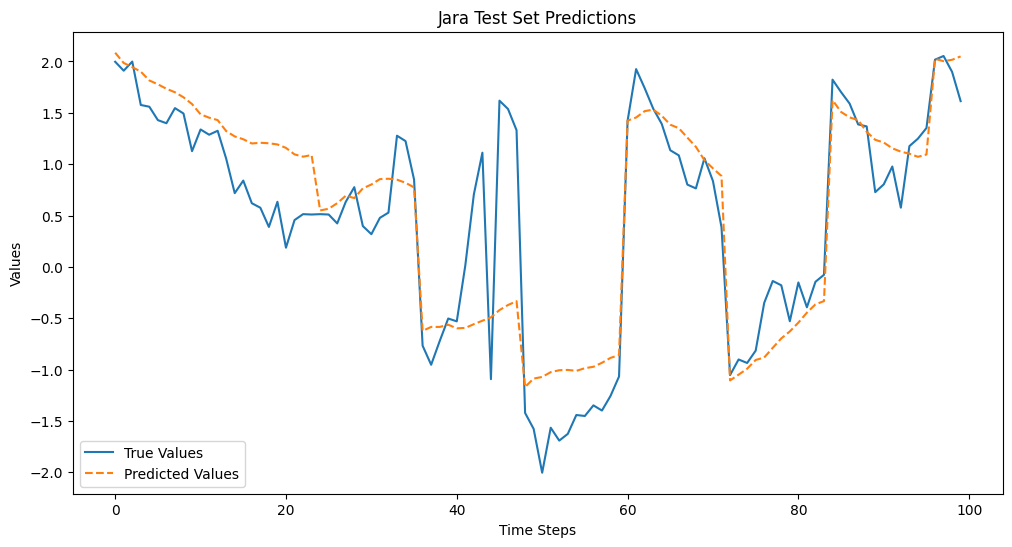

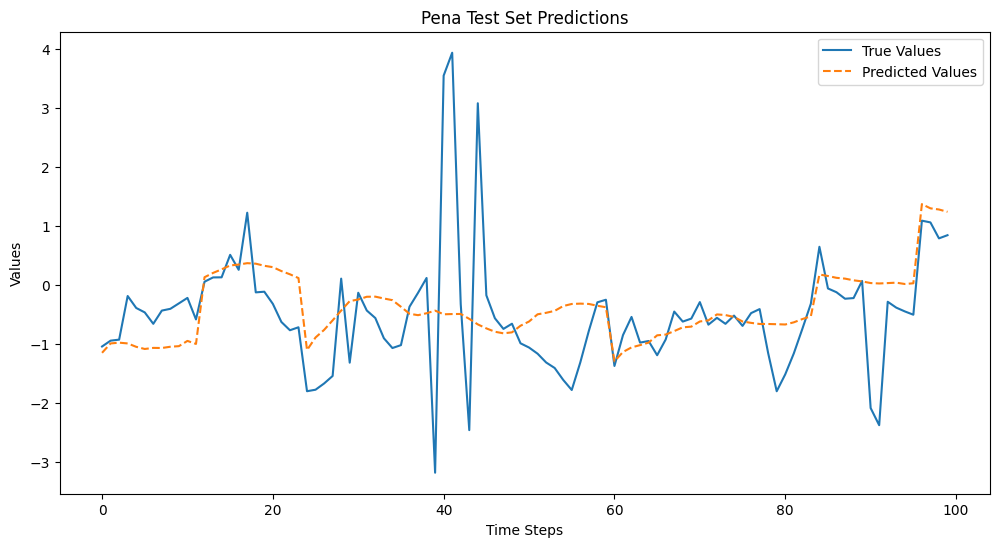

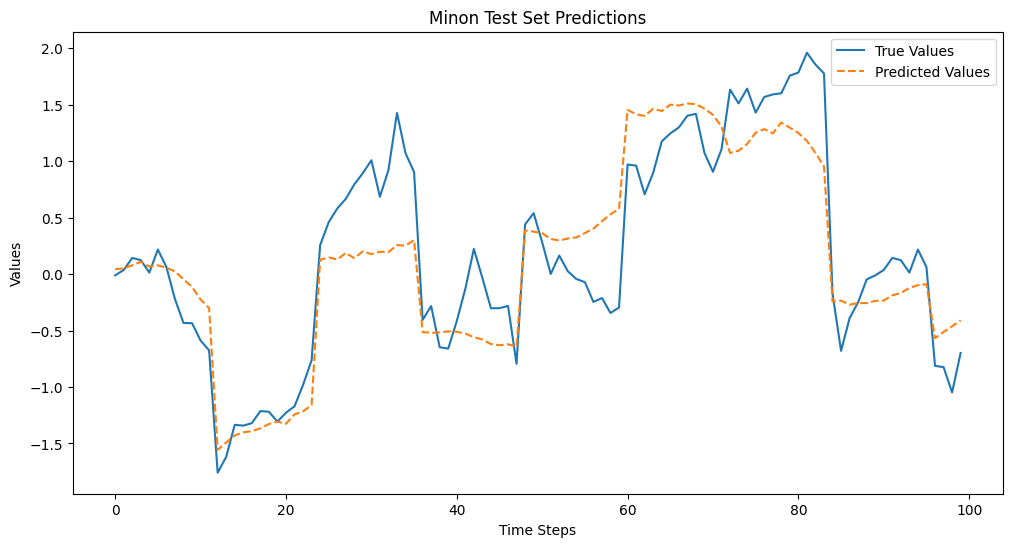

In [61]:
# Evaluate the model on each test dataset and get predictions
print("Evaluating on Jara Test Set")
jara_mse, jara_mae, jara_predictions, jara_true_values = evaluate_performance(model, test_loader_jara)
jara_predictions = jara_predictions.flatten()
jara_true_values = jara_true_values.flatten()

print("\nEvaluating on Pena Test Set")
pena_mse, pena_mae, pena_predictions, pena_true_values = evaluate_performance(model, test_loader_pena)
pena_predictions = pena_predictions.flatten()
pena_true_values = pena_true_values.flatten()

print("\nEvaluating on Minon Test Set")
minon_mse, minon_mae, minon_predictions, minon_true_values = evaluate_performance(model, test_loader_minon)
minon_predictions = minon_predictions.flatten()
minon_true_values = minon_true_values.flatten()

# Average metrics
avg_mse = (jara_mse + pena_mse + minon_mse) / 3
avg_mae = (jara_mae + pena_mae + minon_mae) / 3
print(f"\nAverage MSE: {avg_mse:.3f}\nAverage MAE: {avg_mae:.3f}")

plot_predictions(jara_true_values[:100], jara_predictions[:100], 'Jara Test Set Predictions')
plot_predictions(pena_true_values[:100], pena_predictions[:100], 'Pena Test Set Predictions')
plot_predictions(minon_true_values[:100], minon_predictions[:100], 'Minon Test Set Predictions')


#### V

In [62]:
## JARA
train_loader_jara = prepare_data(jara_train['V'], horizon, input_size)
val_loader_jara = prepare_data(jara_val['V'], horizon, input_size)
test_loader_jara = prepare_data(jara_test['V'], horizon, input_size)

## PENA
train_loader_pena = prepare_data(pena_train['V'], horizon, input_size)
val_loader_pena = prepare_data(pena_val['V'], horizon, input_size)
test_loader_pena = prepare_data(pena_test['V'], horizon, input_size)

## MINON
train_loader_minon = prepare_data(minon_train['V'], horizon, input_size)
val_loader_minon = prepare_data(minon_val['V'], horizon, input_size)
test_loader_minon = prepare_data(minon_test['V'], horizon, input_size)

In [63]:
# Concatenate the training datasets
combined_train = pd.concat([jara_train, pena_train, minon_train])

# Prepare the combined training data loader
train_loader = prepare_data(combined_train['V'], horizon, input_size)

# Prepare separate validation data loaders
val_loader_jara = prepare_data(jara_val['V'], horizon, input_size)
val_loader_pena = prepare_data(pena_val['V'], horizon, input_size)
val_loader_minon = prepare_data(minon_val['V'], horizon, input_size)

model = NHITS(input_size, hidden_size, horizon, num_blocks)

# Train model with separate validation sets
def train_model_with_separate_validation(model, train_loader, val_loaders, num_epochs, learning_rate):
    model.to(device)  # Move model to the device
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_losses = []
        model.eval()
        with torch.no_grad():
            for val_loader in val_loaders:
                val_loss = 0.0
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                val_losses.append(val_loss / len(val_loader))
        
        avg_val_loss = sum(val_losses) / len(val_losses)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Avg Val Loss: {avg_val_loss:.4f}')


# Train the model
val_loaders = [val_loader_jara, val_loader_pena, val_loader_minon]
train_model_with_separate_validation(model, train_loader, val_loaders, num_epochs, learning_rate)

Epoch 1, Train Loss: 0.5488, Avg Val Loss: 0.4013
Epoch 2, Train Loss: 0.4265, Avg Val Loss: 0.3901
Epoch 3, Train Loss: 0.4199, Avg Val Loss: 0.3867
Epoch 4, Train Loss: 0.4157, Avg Val Loss: 0.3855
Epoch 5, Train Loss: 0.4125, Avg Val Loss: 0.3819
Epoch 6, Train Loss: 0.4086, Avg Val Loss: 0.3796
Epoch 7, Train Loss: 0.4052, Avg Val Loss: 0.3777
Epoch 8, Train Loss: 0.4036, Avg Val Loss: 0.3752
Epoch 9, Train Loss: 0.4019, Avg Val Loss: 0.3766
Epoch 10, Train Loss: 0.4002, Avg Val Loss: 0.3753
Epoch 11, Train Loss: 0.3995, Avg Val Loss: 0.3779
Epoch 12, Train Loss: 0.3983, Avg Val Loss: 0.3738
Epoch 13, Train Loss: 0.3980, Avg Val Loss: 0.3745
Epoch 14, Train Loss: 0.3966, Avg Val Loss: 0.3726
Epoch 15, Train Loss: 0.3957, Avg Val Loss: 0.3736
Epoch 16, Train Loss: 0.3951, Avg Val Loss: 0.3713
Epoch 17, Train Loss: 0.3945, Avg Val Loss: 0.3705
Epoch 18, Train Loss: 0.3940, Avg Val Loss: 0.3719
Epoch 19, Train Loss: 0.3943, Avg Val Loss: 0.3731
Epoch 20, Train Loss: 0.3929, Avg Val Lo

Evaluating on Jara Test Set
MSE: 0.3097
MAE: 0.4090

Evaluating on Pena Test Set
MSE: 0.4782
MAE: 0.4985

Evaluating on Minon Test Set
MSE: 0.3499
MAE: 0.4252

Average MSE: 0.379
Average MAE: 0.444


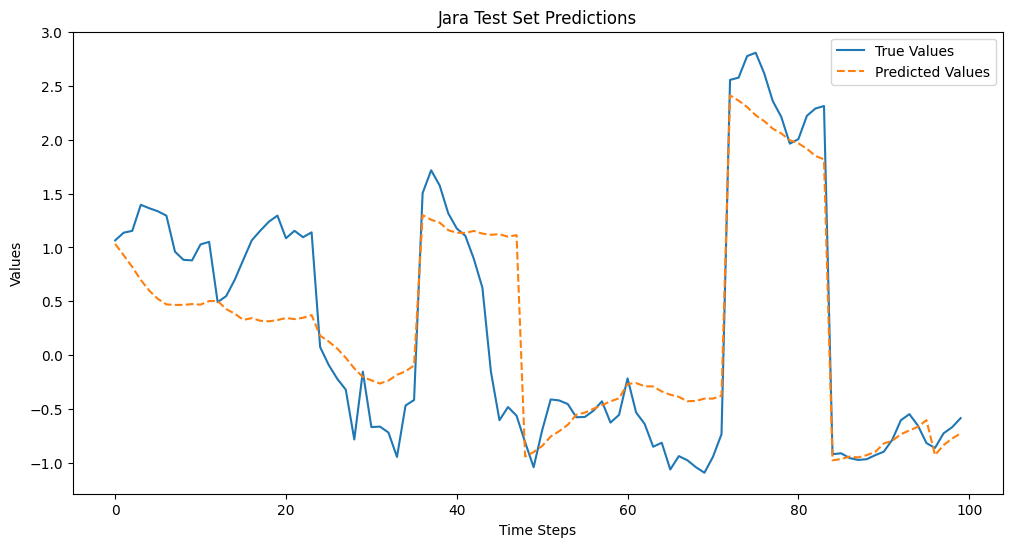

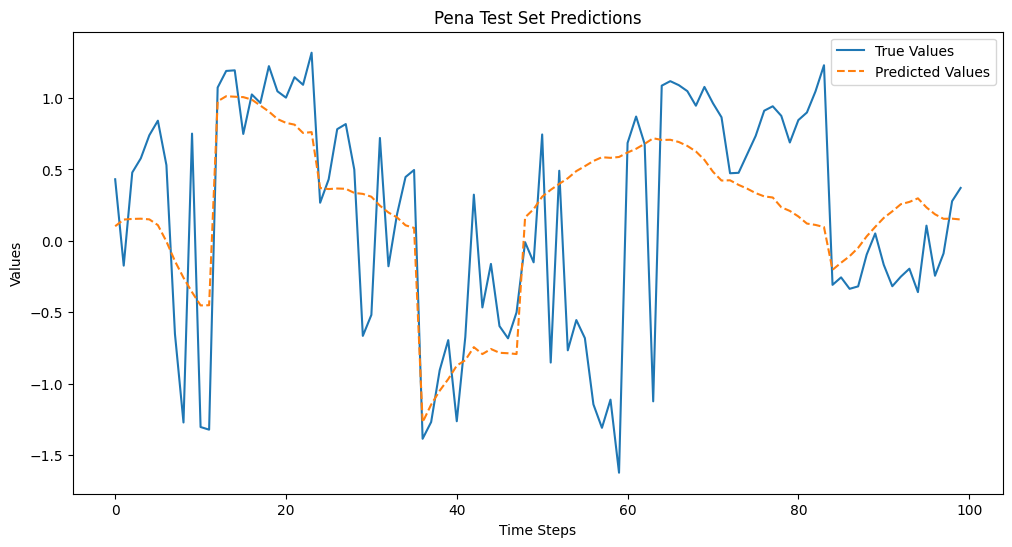

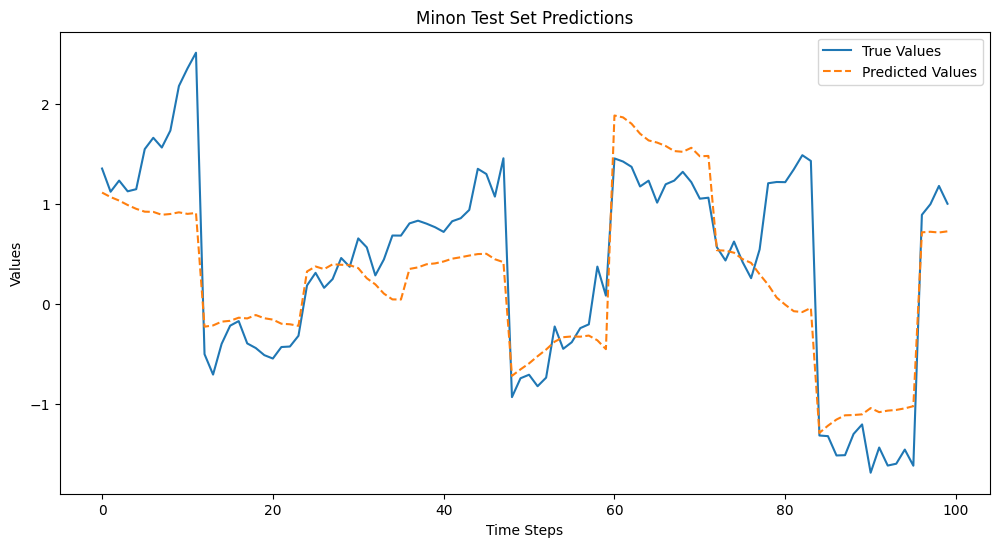

In [65]:
# Evaluate the model on each test dataset and get predictions
print("Evaluating on Jara Test Set")
jara_mse, jara_mae, jara_predictions, jara_true_values = evaluate_performance(model, test_loader_jara)
jara_predictions = jara_predictions.flatten()
jara_true_values = jara_true_values.flatten()

print("\nEvaluating on Pena Test Set")
pena_mse, pena_mae, pena_predictions, pena_true_values = evaluate_performance(model, test_loader_pena)
pena_predictions = pena_predictions.flatten()
pena_true_values = pena_true_values.flatten()

print("\nEvaluating on Minon Test Set")
minon_mse, minon_mae, minon_predictions, minon_true_values = evaluate_performance(model, test_loader_minon)
minon_predictions = minon_predictions.flatten()
minon_true_values = minon_true_values.flatten()

# Average metrics
avg_mse = (jara_mse + pena_mse + minon_mse) / 3
avg_mae = (jara_mae + pena_mae + minon_mae) / 3
print(f"\nAverage MSE: {avg_mse:.3f}\nAverage MAE: {avg_mae:.3f}")

plot_predictions(jara_true_values[:100], jara_predictions[:100], 'Jara Test Set Predictions')
plot_predictions(pena_true_values[:100], pena_predictions[:100], 'Pena Test Set Predictions')
plot_predictions(minon_true_values[:100], minon_predictions[:100], 'Minon Test Set Predictions')

## PatchTST

Se presentan dos opciones de predicción. Combinar las 3 fuentes e intentar predecir las 3 (la correlación espacial podría ayudar), predecir una a una (la tarea es menos compleja)

In [10]:
# Cambiar nombres de las columnas para incluir el prefijo adecuado
jara = jara.rename(columns=lambda col: f'jara_{col}')
pena = pena.rename(columns=lambda col: f'pena_{col}')
minon = minon.rename(columns=lambda col: f'minon_{col}')

# Unir los DataFrames basados en las fechas comunes
combined_df = jara.join([pena, minon], how='inner')

# Restablecer el índice para incluir una columna 'date' con los timestamps
data_all = combined_df.reset_index()

# Datos individuales
data_jara = pd.read_csv('./data/jara_processed.csv')
data_pena = pd.read_csv('./data/pena_processed.csv')
data_minon = pd.read_csv('./data/minon_processed.csv')

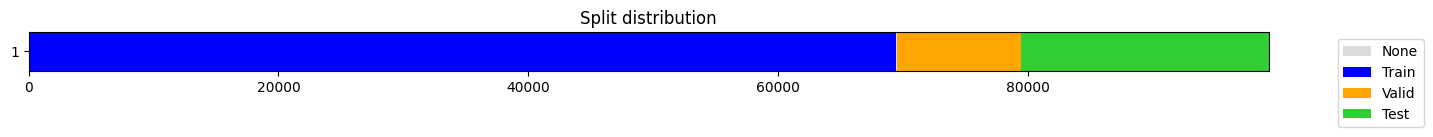

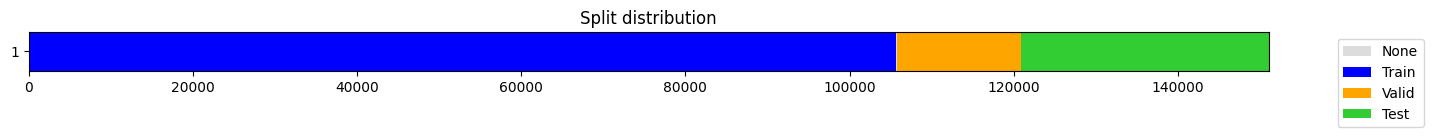

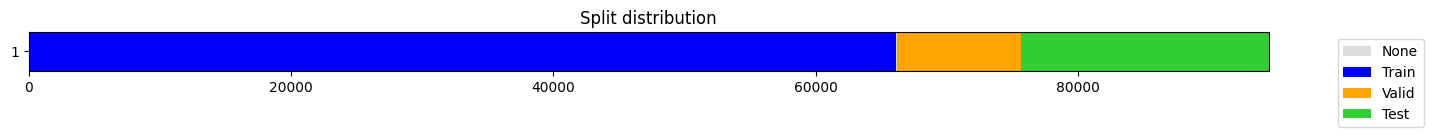

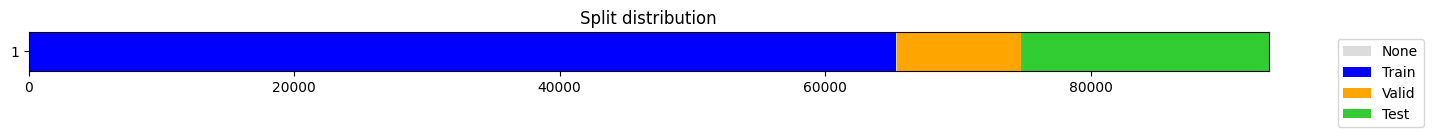

In [11]:
fcst_history = 72 # # steps in the past
fcst_horizon = 12 # # steps in the future

valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

datetime_col = "date"

splits_jara = get_forecasting_splits(data_jara, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col, valid_size=valid_size, test_size=test_size)
splits_pena = get_forecasting_splits(data_pena, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col, valid_size=valid_size, test_size=test_size)
splits_minon = get_forecasting_splits(data_minon, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col, valid_size=valid_size, test_size=test_size)

splits_all = get_forecasting_splits(data_all, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col, valid_size=valid_size, test_size=test_size)

In [12]:
x_vars_pena = data_pena.columns[1:]
y_vars_pena = data_pena.columns[1:]

x_vars_jara = data_jara.columns[1:]
y_vars_jara = data_jara.columns[1:]

x_vars_minon = data_minon.columns[1:]
y_vars_minon = data_minon.columns[1:]

x_vars_all = combined_df.columns[1:]
y_vars_all = combined_df.columns[1:]

X_jara, y_jara = prepare_forecasting_data(data_jara, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars_jara, y_vars=y_vars_jara)
X_pena, y_pena = prepare_forecasting_data(data_pena, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars_pena, y_vars=y_vars_pena)
X_minon, y_minon = prepare_forecasting_data(data_minon, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars_minon, y_vars=y_vars_minon)

X_all, y_all = prepare_forecasting_data(combined_df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars_all, y_vars=y_vars_all)

Pruebas:
- Aumentando la ventana de contexto de 24h a 72h los resultados mejoran
- El modelo grande (16 cabezas, dimesión 128, dimensión FC 256) funciona peor con datos de una localización que el modelo pequeño (4 cabezas, dimesión 32, dimensión FC 128), debido a que produce overfitting. En cambio, para la tarea de predecir los 3 conjuntos a la vez, funciona ligeramente mejor el modelo grande.
- Diversas pruebas variando el tamaño de los parches y los strides.

In [38]:
arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads (4/16)
    d_model=64,  # dimension of model (32/128)
    d_ff=128,  # dimension of fully connected network (128/256)
    attn_dropout=0, # dropout applied to the attention weights
    dropout=0.2,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=2,  # length of the patch applied to the time series to create patches
    stride=1,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

learn = TSForecaster(X_minon, y_minon, splits=splits_minon, batch_size=16, path="models", arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())

n_epochs = 25
lr_max = 0.001
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST_72_12_minon.pt')

learn.load('c:\\Users\\nobody\\Downloads\\Master\\series temporales\\WindPrediction\\models\\patchTST_72_12_minon.pt')

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: left;">
      <th>epoch</th>
      <th>train_loss</th>
      <th>valid_loss</th>
      <th>mse</th>
      <th>mae</th>
      <th>time</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>0.416793</td>
      <td>0.391361</td>
      <td>0.391361</td>
      <td>0.447399</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>1</td>
      <td>0.446253</td>
      <td>0.421622</td>
      <td>0.421622</td>
      <td>0.467487</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>2</td>
      <td>0.431960</td>
      <td>0.393392</td>
      <td>0.393392</td>
      <td>0.451617</td>
      <td>00:25</td>
    </tr>
    <tr>
      <td>3</td>
      <td>0.421818</td>
      <td>0.384245</td>
      <td>0.384245</td>
      <td>0.442155</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>4</td>
      <td>0.438167</td>
      <td>0.382020</td>
      <td>0.382020</td>
      <td>0.441804</td>
      <td>00:25</td>
    </tr>
    <tr>
      <td>5</td>
      <td>0.407944</td>
      <td>0.380656</td>
      <td>0.380656</td>
      <td>0.436831</td>
      <td>00:24</td>
    </tr>
    <tr>
      <td>6</td>
      <td>0.389754</td>
      <td>0.378911</td>
      <td>0.378911</td>
      <td>0.437164</td>
      <td>00:24</td>
    </tr>
    <tr>
      <td>7</td>
      <td>0.405116</td>
      <td>0.376377</td>
      <td>0.376377</td>
      <td>0.436089</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>8</td>
      <td>0.396542</td>
      <td>0.376139</td>
      <td>0.376139</td>
      <td>0.434945</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>9</td>
      <td>0.406162</td>
      <td>0.373119</td>
      <td>0.373119</td>
      <td>0.433389</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>10</td>
      <td>0.399372</td>
      <td>0.373321</td>
      <td>0.373321</td>
      <td>0.432620</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>11</td>
      <td>0.396505</td>
      <td>0.375119</td>
      <td>0.375119</td>
      <td>0.433491</td>
      <td>00:25</td>
    </tr>
    <tr>
      <td>12</td>
      <td>0.378083</td>
      <td>0.371822</td>
      <td>0.371822</td>
      <td>0.432065</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>13</td>
      <td>0.398943</td>
      <td>0.369390</td>
      <td>0.369390</td>
      <td>0.432069</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>14</td>
      <td>0.420634</td>
      <td>0.371699</td>
      <td>0.371699</td>
      <td>0.432384</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>15</td>
      <td>0.397331</td>
      <td>0.368917</td>
      <td>0.368917</td>
      <td>0.430808</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>16</td>
      <td>0.389218</td>
      <td>0.370711</td>
      <td>0.370711</td>
      <td>0.431381</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>17</td>
      <td>0.388381</td>
      <td>0.369155</td>
      <td>0.369155</td>
      <td>0.431718</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>18</td>
      <td>0.381387</td>
      <td>0.368380</td>
      <td>0.368380</td>
      <td>0.430788</td>
      <td>00:24</td>
    </tr>
    <tr>
      <td>19</td>
      <td>0.355451</td>
      <td>0.369650</td>
      <td>0.369650</td>
      <td>0.430938</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>20</td>
      <td>0.400133</td>
      <td>0.369627</td>
      <td>0.369627</td>
      <td>0.431649</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>21</td>
      <td>0.373800</td>
      <td>0.370095</td>
      <td>0.370095</td>
      <td>0.431346</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>22</td>
      <td>0.385256</td>
      <td>0.371248</td>
      <td>0.371248</td>
      <td>0.432067</td>
      <td>00:26</td>
    </tr>
    <tr>
      <td>23</td>
      <td>0.374814</td>
      <td>0.371361</td>
      <td>0.371361</td>
      <td>0.432070</td>
      <td>00:25</td>
    </tr>
    <tr>
      <td>24</td>
      <td>0.381657</td>
      <td>0.371834</td>
      <td>0.371834</td>
      <td>0.432190</td>
      <td>00:26</td>
    </tr>
  </tbody>
</table>


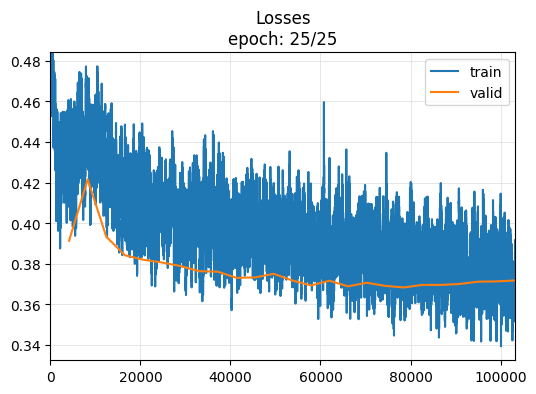

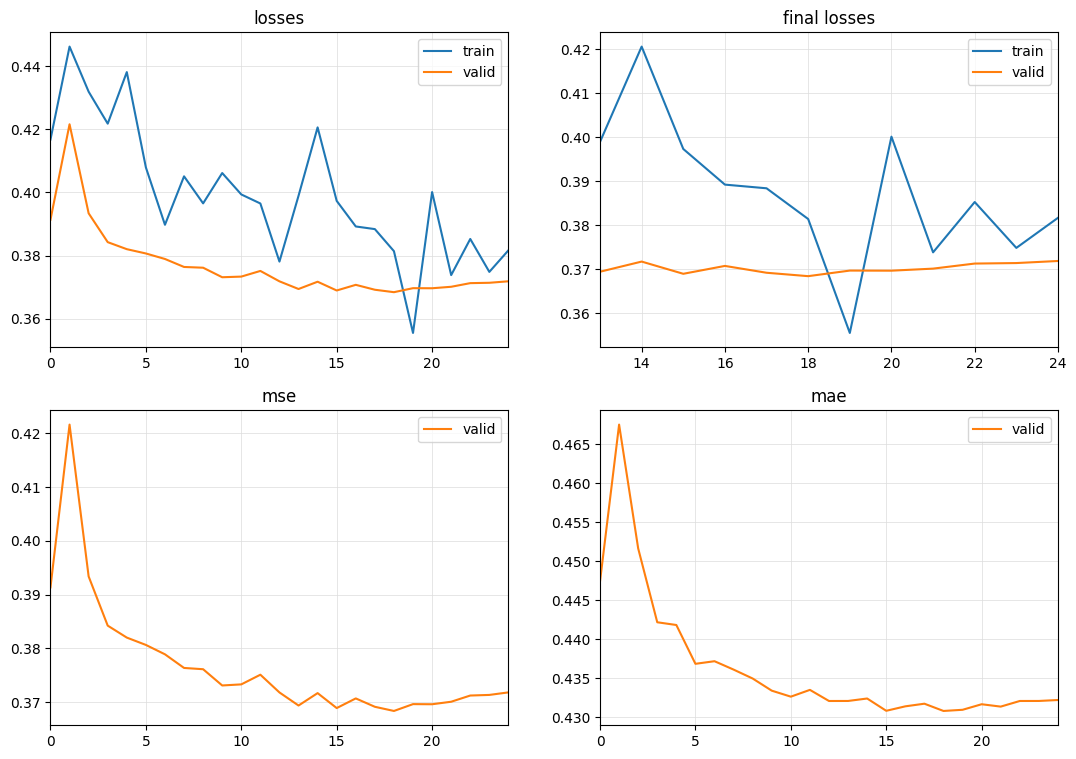

Error en test

In [ ]:
def test_forecaster(learn, X, y, splits):
    y_preds, *_ = learn.get_X_preds(X[splits[2]])
    y_preds = to_np(y_preds)
    y_true = y[splits[2]]
    mse_score = mean_squared_error(y_true.flatten(), y_preds.flatten())
    mae_score = mean_absolute_error(y_true.flatten(), y_preds.flatten())

    X_test = X[splits[2]]
    y_test = y[splits[2]]
    plot_forecast(X_test, y_test, y_preds, sel_vars=True)

    return mse_score, mae_score

All together

In [ ]:
learn = load_learner('models/patchTST_72_12_all.pt')

mse_score, mae_score = test_forecaster(learn, X_all, y_all, splits_all)

print("MSE: ", mse_score)
print("MAE: ", mae_score)

Jara

In [ ]:
learn = load_learner('models/patchTST_72_12_jara.pt')

mse_score, mae_score = test_forecaster(learn, X_jara, y_jara, splits_jara)

print("MSE: ", mse_score)
print("MAE: ", mae_score)

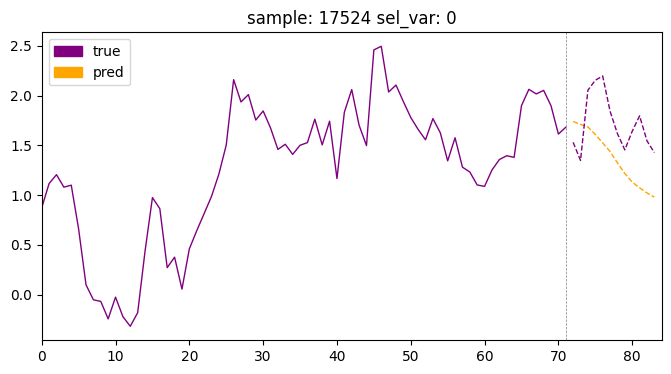
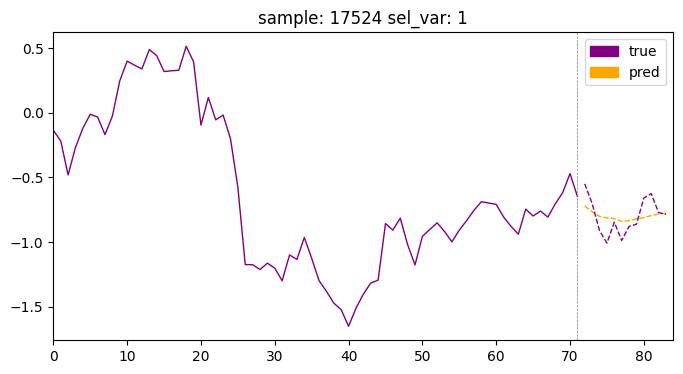

MSE:  0.3210632001893965

MAE:  0.41700508090497984


Peñaparda

In [ ]:
learn = load_learner('models/patchTST_72_12_pena.pt')

mse_score, mae_score = test_forecaster(learn, X_pena, y_pena, splits_pena)

print("MSE: ", mse_score)
print("MAE: ", mae_score)

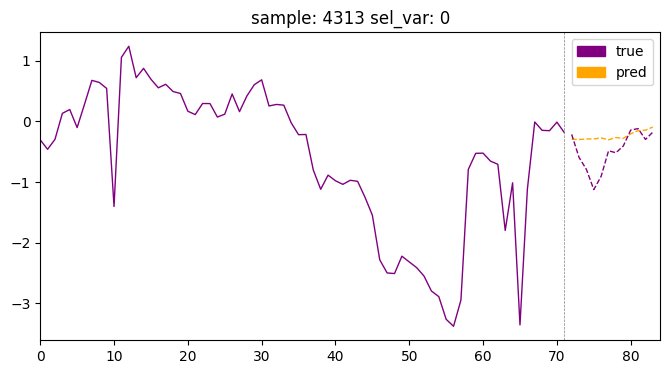
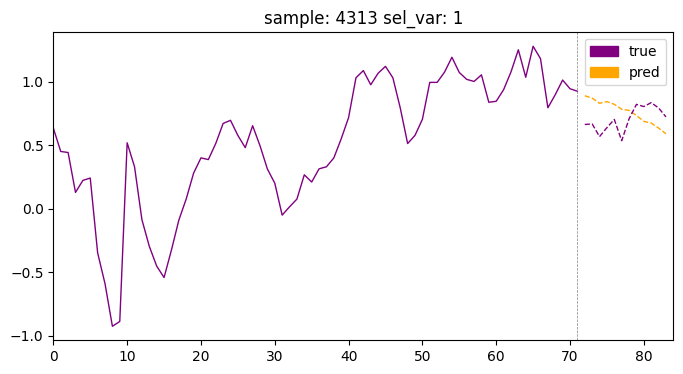

MSE:  0.5207466789510615

MAE:  0.49945728484483726


Miñón

In [ ]:
learn = load_learner('models/patchTST_72_12_minon.pt')

mse_score, mae_score = test_forecaster(learn, X_minon, y_minon, splits_minon)

print("MSE: ", mse_score)
print("MAE: ", mae_score)

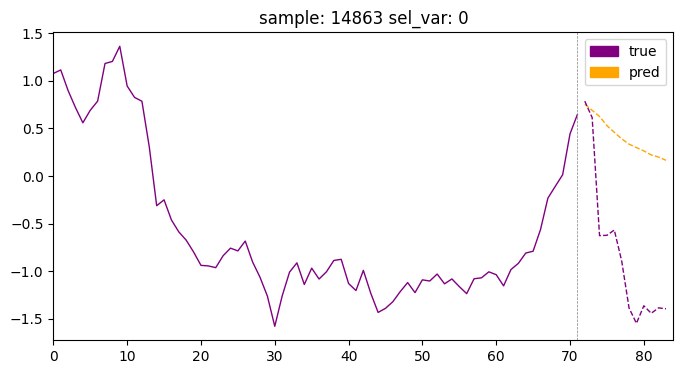
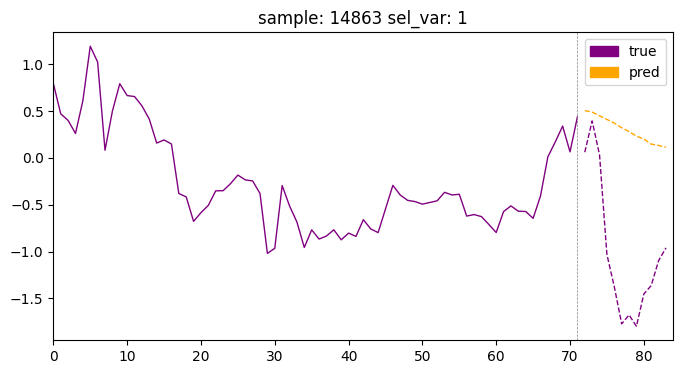

MSE:  0.3703368837454859

MAE:  0.4361471182203373
